In [1]:
# Use this cell to regroup all your imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

# 🏆 Le Wagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

🏆 Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- "Collapse all headings" from the "command palette" (Cmd + Shift + P)
- Stay idempotent (restart & run all should never crash)
- Name and delete variables carefully

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y` 😈
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [2]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split

source_df = pd.read_csv('data/train.csv')

source_df
X = source_df.drop(columns = ["Id","SalePrice"])
y = source_df["SalePrice"]




In [3]:
X['Alley'].unique()


array([nan, 'Grvl', 'Pave'], dtype=object)

# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [4]:
# YOUR CODE HERE
X.dtypes.value_counts() 

#There are 43 categorical variables and 38 numerical variables at first glance

object     43
int64      33
float64     3
dtype: int64

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [6]:
# YOUR CODE HERE
feat_categorical_nunique= X.select_dtypes(include = 'object').nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with ~50 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

In [7]:
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

(array([18., 16.,  4.,  2.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

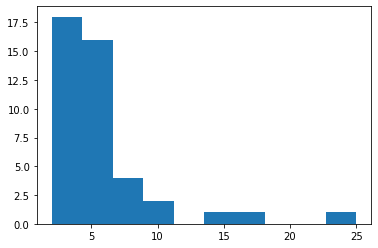

In [8]:
# Your Code here

plt.hist(feat_categorical_nunique)

💡 As a starter, what about simply **removing** all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store features names to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [9]:
# YOUR CODE HERE
#Process: Mask features, drop na, grabe the index and convert to a list
masked_features = feat_categorical_nunique.mask(feat_categorical_nunique>6)
feat_categorical_small_list = masked_features.dropna()
feat_categorical_small = list(feat_categorical_small_list.index)
feat_categorical_small



['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [10]:
# YOUR CODE HERE
len(feat_categorical_small)


34

🧪 Test your code below (and clear the cell once it passed)

In [11]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.9.8, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/josephgulay/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/josephgulay/code/roadbusta/data-challenges-recap/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.05s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## 1.2 Baseline pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [12]:
#Create a numerical column list
feat_numerical= list(X.select_dtypes(include = ['int64', 'float64']).columns)

In [13]:
# YOUR CODE HERE
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )


prep

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [14]:
X_trans = prep.fit_transform(X)

❓ Look at the **shape** of your preprocessed dataframe.

In [15]:
# YOUR CODE HERE
shape_preproc_baseline = X_trans.shape

# Next step- troubleshoot this- maybe they include the sale price as a value to be transformed?

🧪 Test your code below

In [16]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.9.8, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/josephgulay/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/josephgulay/code/roadbusta/data-challenges-recap/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.04s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


### b) Add estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [17]:
# YOUR CODE HERE
from sklearn.tree import DecisionTreeRegressor

pipe_baseline = make_pipeline(prep,
                              DecisionTreeRegressor()
                              )

pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'Lo...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- We will need to create our custom `sklearn.metrics.scorer` object so as to pass to any cross-validation or grid search as below


👉 Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
👉 Create also the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` always tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmse_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [18]:
# YOUR CODE HERE
#Scoring based on RMSE
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

#This is our metric to miinimze
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5 )

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5 )


❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    

Store your mean score as `score_baseline`

In [19]:
# YOUR CODE HERE
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()

### d) Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [20]:
# YOUR CODE HERE
test_data = pd.read_csv("data/test.csv")

X_test = test_data.drop(columns = "Id")

pipe_baseline.fit(X,y)

y_pred = pipe_baseline.predict(X_test)

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [21]:
# YOUR CODE HERE
baseline_submission = pd.DataFrame(index = test_data['Id'], data = y_pred, columns = ['SalePrice'])
# baseline_submission['SalePrice'] = y_pred
# baseline_submission.to_csv('data/submission_baseline.csv')

In [22]:
baseline_submission

,SalePrice
Id,
1461,129000.0
1462,157000.0
1463,204000.0
1464,169000.0
1465,210000.0
...,...
2915,82500.0
2916,83500.0
2917,139000.0


In [23]:
baseline_submission.to_csv('data/submission_baseline.csv')

🧪 Test your code

In [24]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.9.8, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/josephgulay/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/josephgulay/code/roadbusta/data-challenges-recap/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-3.4.0
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.25s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below: **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [25]:
from sklearn.preprocessing import OrdinalEncoder

In [26]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
# feature_A_sorted_values = ['bad', 'average', 'good'] 
# feature_B_sorted_values = ['dirty', 'clean', 'new']

# encoder = OrdinalEncoder(
#     categories=[
#         feature_A_sorted_values,
#         feature_B_sorted_values
#     ],
#     handle_unknown="use_encoded_value",
#     unknown_value=-1
# )

# # Just some random training data
# XX = [
#     ['good', 'dirty'],
#     ['bad', 'new'],
#     ['average', 'clean'],
# ]

# encoder.fit(XX)

# encoder.transform([
#         ['bad', "dirty"],
#         ["average", "clean"],
#         ['good', 'new'],
#         ['bad', 'oooops never seen this label before']
# ])





---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [27]:
#List categorical features
feat_categorical_nunique

#Ordinal array
ordinal_X = X[["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence"]]


#Define and sort ord_cat_list
ord_cat_list = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence"]
ord_cat_list.sort()

#Note that this is in reverse order
BsmtCond_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtFinType1_s_val = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2_s_val = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtQual_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
ExterCond_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
ExterQual_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
Fence_s_val = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']
FireplaceQu_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageCond_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageFinish_s_val = ['Fin', 'RFn', 'Unf', 'NA']
GarageQual_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
HeatingQC_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
KitchenQual_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
PoolQC_s_val = ['Ex', 'Gd', 'TA', 'Fa', 'NA']

#Reverse the order of the list
BsmtCond_s_val.reverse() 
BsmtFinType1_s_val.reverse()
BsmtFinType2_s_val.reverse()
BsmtQual_s_val.reverse() 
ExterCond_s_val.reverse() 
ExterQual_s_val.reverse() 
Fence_s_val.reverse() 
FireplaceQu_s_val.reverse() 
GarageCond_s_val.reverse() 
GarageFinish_s_val.reverse()
GarageQual_s_val.reverse() 
HeatingQC_s_val.reverse() 
KitchenQual_s_val.reverse() 
PoolQC_s_val.reverse() 

# Ordinal categories list
categories=[
        BsmtCond_s_val,
        BsmtFinType1_s_val,
        BsmtFinType2_s_val,
        BsmtQual_s_val,
        ExterCond_s_val,
        ExterQual_s_val,
        Fence_s_val,
        FireplaceQu_s_val,
        GarageCond_s_val,
        GarageFinish_s_val,
        GarageQual_s_val,
        HeatingQC_s_val,
        KitchenQual_s_val,
        PoolQC_s_val
    ]


# Create encoder
o_encoder = OrdinalEncoder(
    categories= categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1
)



In [28]:
#Define test set XX
XX = X[ord_cat_list]
XX

,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtQual,ExterCond,ExterQual,Fence,FireplaceQu,GarageCond,GarageFinish,GarageQual,HeatingQC,KitchenQual,PoolQC
0,TA,GLQ,Unf,Gd,TA,Gd,NaN,NaN,TA,RFn,TA,Ex,Gd,NaN
1,TA,ALQ,Unf,Gd,TA,TA,NaN,TA,TA,RFn,TA,Ex,TA,NaN
2,TA,GLQ,Unf,Gd,TA,Gd,NaN,TA,TA,RFn,TA,Ex,Gd,NaN
3,Gd,ALQ,Unf,TA,TA,TA,NaN,Gd,TA,Unf,TA,Gd,Gd,NaN
4,TA,GLQ,Unf,Gd,TA,Gd,NaN,TA,TA,RFn,TA,Ex,Gd,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TA,Unf,Unf,Gd,TA,TA,NaN,TA,TA,RFn,TA,Ex,TA,NaN
1456,TA,ALQ,Rec,Gd,TA,TA,MnPrv,TA,TA,Unf,TA,TA,TA,NaN
1457,Gd,GLQ,Unf,TA,Gd,Ex,GdPrv,Gd,TA,RFn,TA,Ex,Gd,NaN
1458,TA,GLQ,Rec,TA,TA,TA,NaN,NaN,TA,Unf,TA,Gd,Gd,NaN


In [29]:
#Test the encoder
o_encoder.fit(XX)
o_encoder.transform(XX)[0:10]

array([[ 3.,  6.,  1.,  4.,  2.,  3., -1., -1.,  3.,  2.,  3.,  4.,  3.,
        -1.],
       [ 3.,  5.,  1.,  4.,  2.,  2., -1.,  3.,  3.,  2.,  3.,  4.,  2.,
        -1.],
       [ 3.,  6.,  1.,  4.,  2.,  3., -1.,  3.,  3.,  2.,  3.,  4.,  3.,
        -1.],
       [ 4.,  5.,  1.,  3.,  2.,  2., -1.,  4.,  3.,  1.,  3.,  3.,  3.,
        -1.],
       [ 3.,  6.,  1.,  4.,  2.,  3., -1.,  3.,  3.,  2.,  3.,  4.,  3.,
        -1.],
       [ 3.,  6.,  1.,  4.,  2.,  2.,  3., -1.,  3.,  1.,  3.,  4.,  2.,
        -1.],
       [ 3.,  6.,  1.,  5.,  2.,  3., -1.,  4.,  3.,  2.,  3.,  4.,  3.,
        -1.],
       [ 3.,  5.,  4.,  4.,  2.,  2., -1.,  3.,  3.,  2.,  3.,  4.,  2.,
        -1.],
       [ 3.,  1.,  1.,  3.,  2.,  2., -1.,  3.,  3.,  1.,  2.,  3.,  2.,
        -1.],
       [ 3.,  6.,  1.,  3.,  2.,  2., -1.,  3.,  3.,  2.,  4.,  4.,  2.,
        -1.]])

In [30]:
cat_list = list(X.select_dtypes(include = 'object'))
nom_cat_list = [heading for heading in cat_list if heading not in ord_cat_list]
nom_cat_list

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'PavedDrive',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [31]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [32]:
# YOUR CODE HERE
preproc_ordinal = make_pipeline(o_encoder)

preproc_nominal = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore', sparse = 'False')
                        )

preproc_num = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )
prep_transformer = make_column_transformer((preproc_ordinal, ord_cat_list),
                               (preproc_nominal, nom_cat_list),
                               (preproc_num, feat_numerical), sparse_threshold=0
                              )

prep_transformer

ColumnTransformer(sparse_threshold=0,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['NA',
                                                                              'Unf',
                                                                              'LwQ',
                                                                              'Rec',
                                                                              'BLQ',
                                                                              'ALQ',
                                                                              'GLQ'],
                                                                             ['NA',
                                                                              'Unf',
                                                                              'LwQ',
                                                                              'Rec',
                                                                              'BLQ',
                                                                              'ALQ',
                                                                              'GLQ'],
                                                                             ['NA',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['NA',
                                                                              'MnWw',
                                                                              'GdWo',...
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                                  'FullBath', 'HalfBath', 'BedroomAbvGr',
                                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        

### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only option 1 today to start with**. Option 2 and 3 will be corrected in Recap

#### (option 1 - recommended) <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 Mutual Information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [33]:
# YOUR CODE HERE
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_selector = SelectPercentile(mutual_info_regression, percentile = 25)


preproc = make_pipeline(
            prep_transformer,
            preproc_selector)

preproc



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['NA',
                                                                                               'Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['NA',
                                                                                               'Unf',
                                                                                               'LwQ',
                                                                                               'Rec',
                                                                                               'BLQ',
                                                                                               'ALQ',
                                                                                               'GLQ'],
                                                                                              ['NA',
                                                                                               'Unf',
                                                                                               'LwQ',
                                                                                               'Rec',
                                                                                               'BLQ',
                                                                                               'ALQ',
                                                                                               'GLQ'],
                                                                                              ['NA',
                                                                                               'Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa'...
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                          

In [34]:
X.shape

(1460, 79)

In [35]:
preproc.fit_transform(X,y).shape

(1460, 60)

#### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) importance in combination with an estimator! It train one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

Cherry on the cake, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the `SequentialFeatureSelector` transformer: This will recursively filter-out least important features according to `feature_permutation` importance!  

However, such process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already outputs some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn has coded for you a [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that

In [36]:
# YOUR CODE HERE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

preproc_selector = SelectFromModel(estimator = RandomForestRegressor())

preproc = make_pipeline(
            prep_transformer,
            preproc_selector)

preproc.fit_transform(X,y).shape




(1460, 21)

#### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick-win is to remove features with the lowest variance. Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Feel free to add a `VarianceThreshold` to the end of your pipeline

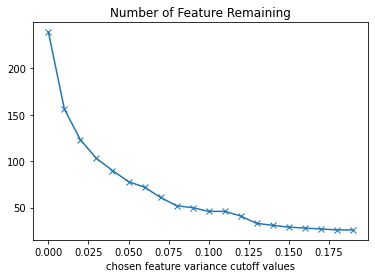

In [37]:
# YOUR CODE HERE

from sklearn.feature_selection import VarianceThreshold

def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer((preproc_ordinal, ord_cat_list),
                               (preproc_nominal, nom_cat_list),
                               (preproc_num, feat_numerical), 
                                sparse_threshold=0,
                                remainder="drop"
                              )

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector)

    return preproc.fit_transform(X).shape[1]

cutoff_values = np.arange(0, 0.2, 0.01)
plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')
plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others. 
- Use statsmodels's `VIF` to check for feature that have the highest multicolionearity

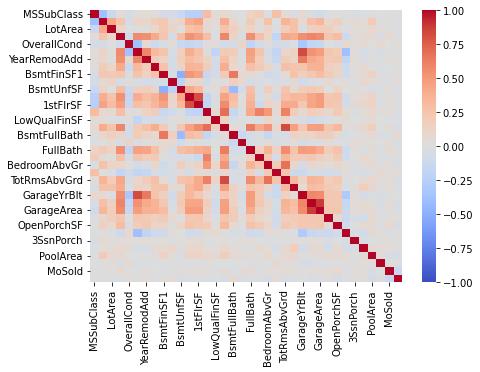

In [38]:
# YOUR CODE HERE
corr_num = X[feat_numerical].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [39]:
# Check which columns to drop based on too high correlation 
num_corr_threshold = 0.8

corr_num = X[feat_numerical].corr()
corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape),k=1).astype(np.bool)).abs()
num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
num_col_to_drop

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others. Feel free to plot a heatmap again

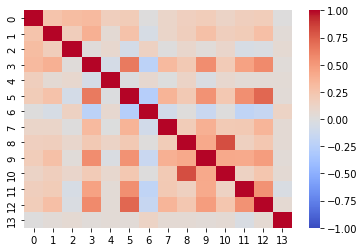

In [40]:
# YOUR CODE HERE
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[ord_cat_list]))
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1);

❓Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (spearman + peasron) correlation threshold. You'll need a custom transformer class

In [41]:
# YOUR CODE HERE
from sklearn.base import BaseEstimator, TransformerMixin


class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_corr_threshold=0.95):
        self.num_corr_threshold = num_corr_threshold

    def fit(self, X, y=None):
        corr_num = X[feat_numerical].corr()
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool)).abs()
        self.num_col_to_drop = [column for column in upper.columns if any(upper[column] > self.num_corr_threshold)]
        self.num_col = X[feat_numerical].columns
        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.num_col)
        return df.drop(columns=self.num_col_to_drop)
    
# Test it here
CustomFeatureSelector(num_corr_threshold=0.2).fit_transform(X[feat_numerical]).head(2)

,MSSubClass,OverallCond,BsmtFinSF2,LowQualFinSF,BsmtHalfBath,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold
0,60,5,0,0,0,0,0,0,2,2008
1,20,8,0,0,1,0,0,0,5,2007


### c) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

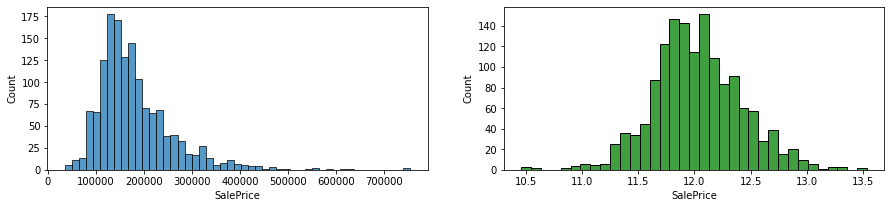

In [42]:
# YOUR CODE HERE
y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green');

In [43]:
# Create your new scorer to minimize
from sklearn.metrics import mean_squared_error, mean_squared_log_error
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

In [44]:
# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## 2.2 Models Iteration ♻

### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

#### Decision Tree Regressor
**Scores**<br>
Initial CV Score: **0.21** <br>
After pre-process improvements: **0.21** <br>
After Gridsearching:

👍 Advantages

- No scaling necessary
- Resistant to outliers
- Intuitive and interpretable
- Allow feature selection (see gini-based feature_importance_)
- Non-Linear modelisation


👎 Disadvantages

- High variance (i.e small change in data has a big change in the tree structure)
- Long training time if grown up to max depth 
- Split data "orthogonally" to feature directions
    - 💡 use PCA upfront to "orient" data

In [45]:
# YOUR CODE HERE
num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )
pipe_baseline = make_pipeline(prep,
                              DecisionTreeRegressor()
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.21060737288993434


In [46]:
# Updated pipeline

# Create ordinal encoder
o_encoder = OrdinalEncoder(
    categories= categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

preproc_ordinal = make_pipeline(o_encoder)

preproc_nominal = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore', sparse = 'False')
                        )

preproc_num = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )
prep_transformer = make_column_transformer((preproc_ordinal, ord_cat_list),
                               (preproc_nominal, nom_cat_list),
                               (preproc_num, feat_numerical), sparse_threshold=0
                              )

preproc_selector = SelectPercentile(mutual_info_regression, percentile = 50)


preproc = make_pipeline(
            prep_transformer,
            preproc_selector)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['NA',
                                                                                               'Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['NA',
                                                                                               'Unf',
                                                                                               'LwQ',
                                                                                               'Rec',
                                                                                               'BLQ',
                                                                                               'ALQ',
                                                                                               'GLQ'],
                                                                                              ['NA',
                                                                                               'Unf',
                                                                                               'LwQ',
                                                                                               'Rec',
                                                                                               'BLQ',
                                                                                               'ALQ',
                                                                                               'GLQ'],
                                                                                              ['NA',
                                                                                               'Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa'...
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                          

In [47]:
#check shape
preproc_fitted = preproc.fit(X,y)
preproc.transform(X).shape
# preproc_fitted_log = preproc.fit(X,y_log)
# preproc_fitted_log.transform(X).shape

(1460, 119)

In [48]:
#Updated baseline
pipe_baseline = make_pipeline(preproc,
                              DecisionTreeRegressor()
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.20609336986601115


In [49]:
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 119)

In [65]:
#Using y_log

pipe_baseline = make_pipeline(preproc,
                              DecisionTreeRegressor()
                              )

cv_score = cross_val_score(pipe_baseline, X, y_log, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmse)

score_baseline = cv_score.mean()
print(score_baseline)

0.20603483107146392


In [51]:
# We can see that

#### Random Forest Regressor
**Scores**<br>
Initial CV Score: **0.15** <br>
After pre-process improvements: **0.14** <br>
After Gridsearching:

👍 Advantages:

- Reduces variance/overfitting
- Can be applied to any model

👎 Disadvantages

- Complex structure
- High training time
- Disregards the performance of individual sub-models

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )
pipe_baseline = make_pipeline(prep,
                              RandomForestRegressor()
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.14698521489823735


In [66]:
#Updated baseline
pipe_baseline = make_pipeline(preproc,
                              RandomForestRegressor()
                              )

cv_score = cross_val_score(pipe_baseline, X, y_log, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmse)

score_baseline = cv_score.mean()
print(score_baseline)

0.14151750099486815


#### BaggingRegressor with KNN Regressor
**Scores**<br>
Initial CV Score: **0.22** <br>
After pre-process improvements: **0.21**<br>
After Gridsearching:


In [55]:
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor



In [56]:
#Define Bagging Regressor
weak_learner = KNeighborsRegressor(n_neighbors=3)
bagged_model = BaggingRegressor(weak_learner, n_estimators=40)

num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )
pipe_baseline = make_pipeline(prep,
                              bagged_model
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.21609478076716132


In [57]:
#Updated baseline
#Define Bagging Regressor
weak_learner = KNeighborsRegressor(n_neighbors=3)
bagged_model = BaggingRegressor(weak_learner, n_estimators=40)

pipe_baseline = make_pipeline(preproc,
                              bagged_model
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.20613908795226948


#### Adaboost with DecisionTreeRegressor
**Scores**<br>
Initial CV Score: **0.14** <br>
After pre-process improvements: <br>
After Gridsearching:

In [58]:
from sklearn.ensemble import AdaBoostRegressor

In [59]:
#Define Adaboost Regressor
adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=10),
    n_estimators=80)

num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )
pipe_baseline = make_pipeline(prep,
                              adaboost
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.1460577375198051


#### Gradient Boosting
**Scores**<br>
Initial CV Score: **0.13** <br>
After pre-process improvements: <br>
After Gridsearching:

Only implemented for trees<br>
Generally more performant than AdaBoost

In [60]:
from sklearn.ensemble import GradientBoostingRegressor


In [61]:
# Define Gradient Boosting Regressor here
model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3
)

num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )
pipe_baseline = make_pipeline(prep,
                              model
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.1332159877621843


#### XGBOOST
**Scores**<br>
Initial CV Score: **0.14** <br>
After pre-process improvements: <br>
After Gridsearching:

👍 Advantages:

- Strong sub-models have more influence in final decision
- Reduce bias


👎 Disadvantages:

- Computationally expensive (sequential)
- Easily overfit
- Sensitive to outliers (too much time spent trying to correctly predict them)

In [62]:
from xgboost import XGBRegressor

In [63]:
# Define XGBOOST Regressor here
model = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

num_prep = make_pipeline(SimpleImputer(strategy = 'mean'), 
                         MinMaxScaler()
                        )

cat_prep = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                         OneHotEncoder(handle_unknown = 'ignore')
                        )

prep = make_column_transformer((num_prep, feat_numerical),
                               (cat_prep, feat_categorical_small)
                              )
pipe_baseline = make_pipeline(prep,
                              model
                              )

cv_score = cross_val_score(pipe_baseline, X, y, 
                           cv = 5,
                           n_jobs = -1,
                           scoring = rmsle)

score_baseline = cv_score.mean()
print(score_baseline)

0.13713602666872715


**Scores**<br>
Initial CV Score: **0.14** <br>
After pre-process improvements: <br>
After Gridsearching:

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [64]:
# YOUR CODE HERE